In [14]:
!pip install scipy db-dtypes google-cloud-bigquery-storage statsmodels

In [1]:
import warnings
import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from google.cloud import bigquery
from google.cloud.bigquery import Client

In [2]:
%matplotlib inline
random.seed(42)

In [3]:
client = bigquery.Client()

# Construct a reference to the dataset
dataset_ref = client.dataset("iowa_liquor_sales", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

In [4]:
# List all the tables in the dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset
for table in tables:
    print(f"- {table.table_id}")

- sales


In [5]:
# Construct a reference to the table
table_ref = dataset_ref.table("sales")

# API request - fetch the table
table = client.get_table(table_ref)

## Dataset Description

### Context

This dataset contains the spirits purchase information of Iowa Class “E” liquor licensees by product and date of purchase from January 2021 to January 2022.
The dataset can be used to analyze total spirits sales in Iowa of individual products at the store level.

### Content

The dataset contains of **~3M rows and 24 columns**. The columns are:

1. `invoiceanditemnumber`: concatenated invoice and line number associated with the liquor order. This provides a unique identifier for the individual liquor products included in the store order. 
2. `date`: date of order. 
3. `storenumber`: unique number assigned to the store who ordered the liquor.
4. `storename`: name of store who ordered the liquor. 
5. `address`: address of store who ordered the liquor. 
6. `city`: city where the store who ordered the liquor is located. 
7. `zipcode`: zip code where the store who ordered the liquor is located.
8. `storelocation`: location of store who ordered the liquor. The address, city, state and zip code are geocoded to provide geographic coordinates.
9. `countynumber`: iowa county number for the county where store who ordered the liquor is located.
10. `county`: county where the store who ordered the liquor is located.
11. `category`: category code associated with the liquor ordered.
12. `categoryname`: category of the liquor ordered. 
13. `vendornumber`: the vendor number of the company for the brand of liquor ordered.
14. `vendorname`: the vendor name of the company for the brand of liquor ordered. 
15. `itemnumber`: item number for the individual liquor product ordered.
16. `itemdescription`: description of the individual liquor product ordered. 
17. `pack`: the number of bottles in a case for the liquor ordered.
18. `bottlevolumeml`: volume of each liquor bottle ordered in milliliters.
19. `statebottlecost`: the amount that alcoholic beverages division paid for each bottle of liquor ordered. 
20. `statebottleretail`: the amount the store paid for each bottle of liquor ordered. 
21. `bottlessold`: the number of bottles of liquor ordered by the store.
22. `saledollars`: total cost of liquor order (number of bottles multiplied by the state bottle retail). 
23. `volumesoldliters`: total volume of liquor ordered in liters. (i.e. $\frac{\text{bottle\ volume\ (ml)} \times{} \text{bottles\ sold}}{1000}$).
24. `volumesold_gallons`: total volume of liquor ordered in gallons. (i.e. $\frac{\text{bottle\ volume\ (ml)} \times{} \text{bottles\ sold}}{3785.411784}$).

### Questions ❓

1. How was the trend of the number of bottles sold between January 2021 to January 2022?
2. How much revenue does Iowa make from the business each month? Which product drives the most sales?
3. How many stores ordered the liquor? Which store has the most order?
4. Are there any variations among regions in terms of the most popular product?
5. Are there any differences between product consumption in terms of the season?
6. How many bottles will Iowa sell in the next three months?

In [8]:
query = "SELECT * FROM `bigquery-public-data.iowa_liquor_sales.sales` TABLESAMPLE SYSTEM (1 PERCENT) WHERE EXTRACT(YEAR FROM date) >= 2019"

# Set up the query
query_job = client.query(query)

# API request - run the query, and return a pandas DataFrame
df = query_job.to_dataframe()

# overview of the result dataframe
df

I0000 00:00:1722585858.780551 1795398 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,RINV-04678500004,2023-06-07,6195,DT LIQUOR LLC / DEWITT,301 11TH STREET,DEWITT,52742.0,POINT(-90.534765967 41.826022985),None,CLINTON,...,36900,BARTON NATURALS VODKA,6,1750,7.06,10.59,-30,-317.70,-52.5,-13.86
1,RINV-05156500143,2024-02-28,2201,HAPPY'S WINE & SPIRITS WHOLESALE,5925 UNIVERSITY AVE,CEDAR FALLS,50613.0,POINT(-92.429482021 42.512313981),None,BLACK HAWK,...,17916,ELIJAH CRAIG,12,750,17.52,26.28,-48,-1261.44,-36.0,-9.51
2,RINV-04740600093,2023-07-10,6144,NORTHSIDE LIQUOR AND GROCERY / MASON CITY,1303 N FEDERAL,MASON CITY,50401.0,POINT(-93.200731023 43.163723016),None,CERRO GORDO,...,10807,CROWN ROYAL REGAL APPLE,12,750,17.49,26.24,-24,-629.76,-18.0,-4.75
3,RINV-05218200037,2024-04-11,2656,HY-VEE FOOD STORE / CORNING,300 10TH ST,CORNING,50841.0,POINT(-94.732615023 40.992144989),None,ADAMS,...,21612,TEMPLETON BOURBON,6,750,22.50,33.75,-18,-607.50,-13.5,-3.56
4,RINV-04533600214,2023-03-03,2633,HY-VEE #3 / BDI / DES MOINES,3221 SE 14TH ST,DES MOINES,50320,POINT(-93.5968 41.55392),None,POLK,...,69947,RUMPLE MINZE PEPPERMINT SCHNAPPS LIQUEUR,12,1000,16.49,24.74,-12,-296.88,-12.0,-3.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87099,INV-17782300007,2019-02-26,4255,FAREWAY STORES #058 / ORANGE CITY,512 8TH SE,ORANGE CITY,51041,None,84,SIOUX,...,11788,BLACK VELVET,6,1750,10.45,15.68,1182,18533.76,2068.5,546.43
87100,INV-32575400003,2020-12-09,3524,SAM'S CLUB 6568 / AMES,305 AIRPORT RD,AMES,50010.0,POINT(-93.613648 42.001123),85,STORY,...,11788,BLACK VELVET,6,1750,10.45,15.68,1200,18816.00,2100.0,554.76
87101,INV-47227100011,2022-05-09,2512,HY-VEE WINE AND SPIRITS / IOWA CITY,1720 WATERFRONT DR,IOWA CITY,52240.0,POINT(-91.530439 41.642724),52,JOHNSON,...,36889,BARTON NATURALS,12,1000,3.97,5.96,2400,14304.00,2400.0,634.01
87102,INV-23017500001,2019-11-05,3814,COSTCO WHOLESALE #788 / WDM,7205 MILLS CIVIC PKWY,WEST DES MOINES,50266.0,POINT(-93.806489 41.561342),25,DALLAS,...,987514,KIRKLAND SIGNATURE FRENCH VODKA,6,1750,14.47,21.71,2016,43767.36,3528.0,931.99


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87104 entries, 0 to 87103
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   invoice_and_item_number  87104 non-null  object 
 1   date                     87104 non-null  dbdate 
 2   store_number             87104 non-null  object 
 3   store_name               87104 non-null  object 
 4   address                  87053 non-null  object 
 5   city                     87053 non-null  object 
 6   zip_code                 87053 non-null  object 
 7   store_location           80736 non-null  object 
 8   county_number            55286 non-null  object 
 9   county                   87053 non-null  object 
 10  category                 87084 non-null  object 
 11  category_name            87084 non-null  object 
 12  vendor_number            87104 non-null  object 
 13  vendor_name              87104 non-null  object 
 14  item_number           

### Counting Missing Values

In [11]:
df.isnull().sum().to_frame("null_count")

,null_count
invoice_and_item_number,0
date,0
store_number,0
store_name,0
address,51
city,51
zip_code,51
store_location,6368
county_number,31818
county,51


### Transforming date column values to `datetime`

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
df['date'].dt.year.value_counts().sort_index().to_frame("YEARS_ROW_COUNT")

,YEARS_ROW_COUNT
date,
2019,14686
2020,16202
2021,16308
2022,15875
2023,16102
2024,7931


## Questions

### Question 1

How was the trend of the **number of bottles sold** between **January 2021 to January 2022**?

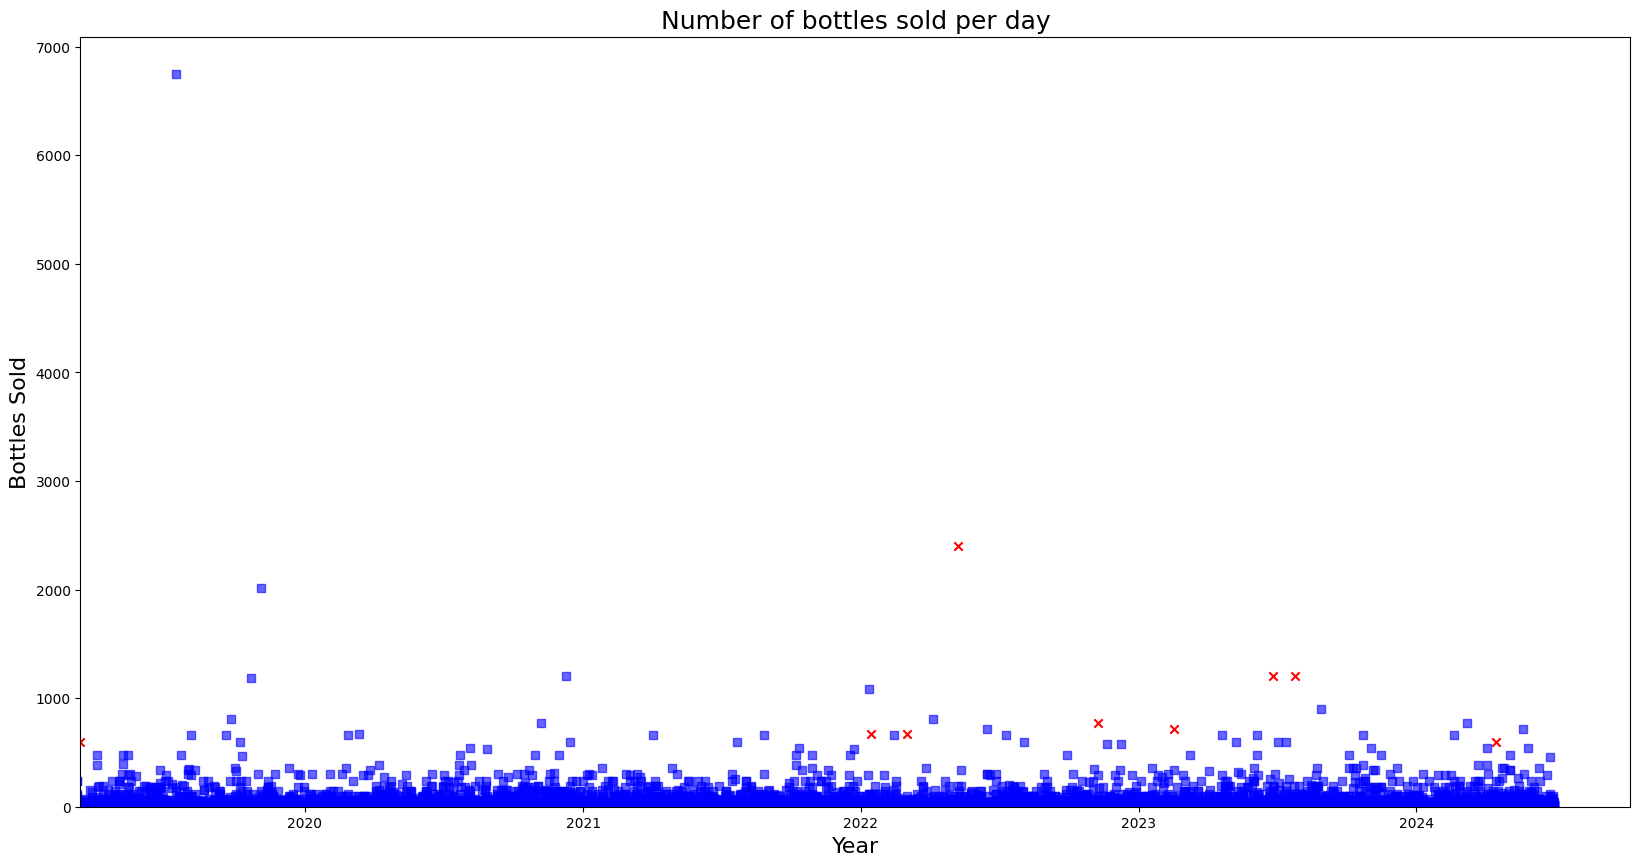

In [30]:
peaks, _ = find_peaks(df.bottles_sold, height=0)
peak_indices = (df.loc[peaks]['bottles_sold'].sort_values(ascending=False)[:9]).index
mask = df.index.isin(peak_indices)

plt.figure(figsize=(20, 10))

plt.scatter(x = df[mask]['date'], y = df[mask]['bottles_sold'], marker = "x", color='red')
plt.scatter(x = df[~mask]['date'], y = df[~mask]['bottles_sold'], marker = 's', color = 'blue', alpha=0.6)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Bottles Sold", fontsize=16)
plt.title("Number of bottles sold per day", fontsize=18)
plt.xlim(left=df[mask]['date'].min())
plt.ylim(bottom=0)
plt.show()

In [33]:
month = np.append(np.arange(1, 13, 1), 1, axis=None)
year = np.append(np.array([2021] * 12), 2022, axis=None)
month

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1])

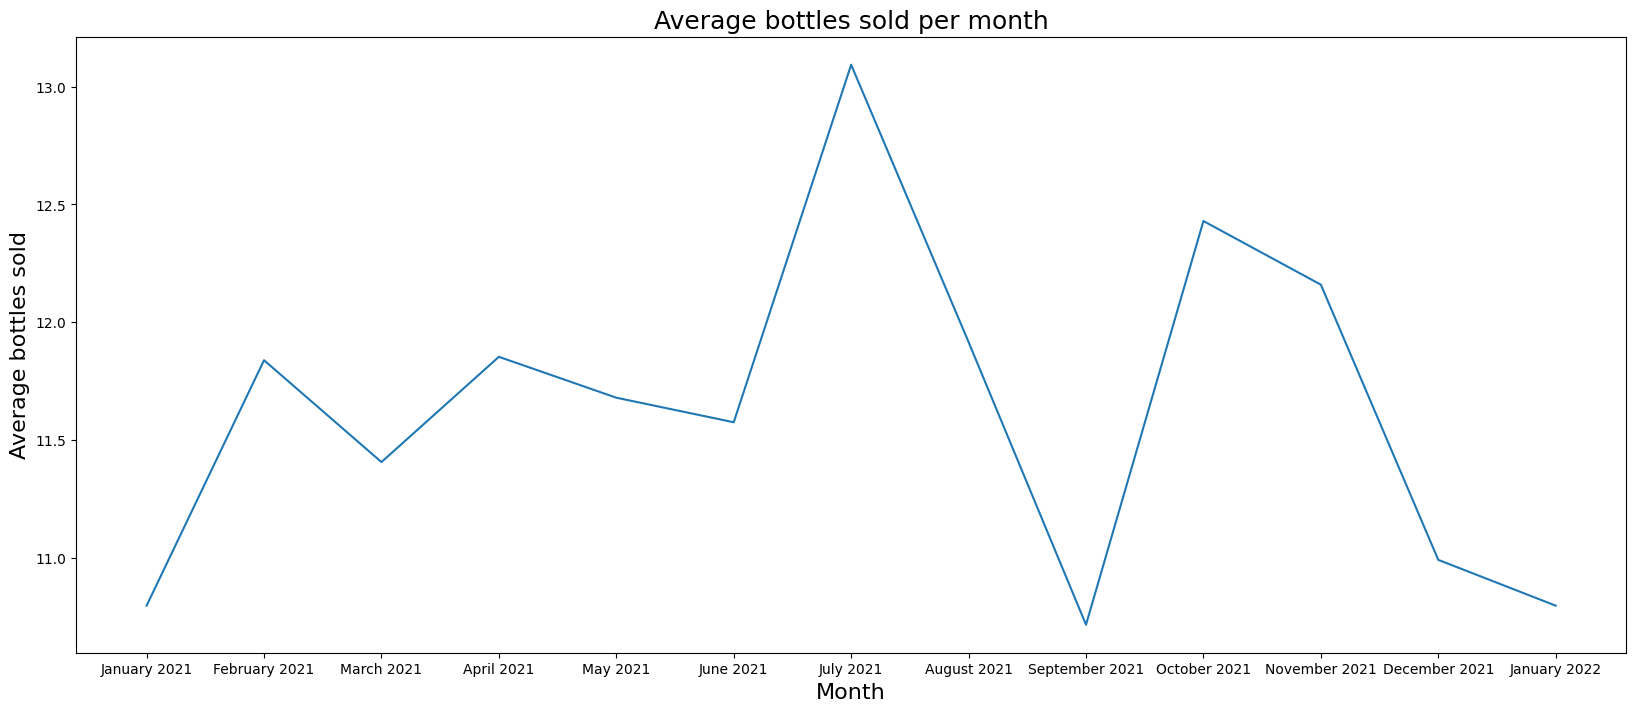

In [32]:
month = np.append(np.arange(1, 13, 1), 1, axis=None)
year = np.append(np.array([2021] * 12), 2022, axis=None)

months = ["", "January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

mean_sale = []
sale_month = []


for i in range(13):
    mask_date = (df['date'].dt.month == pd.to_datetime(str(f"{year[i]}-{month[i]}")).month)
    mean_bottles_sale = df[mask_date]['bottles_sold'].mean()
    mean_sale.append(mean_bottles_sale)
    sale_month.append(str(f"{months[month[i]]} {year[i]}"))

plt.figure(figsize=(20, 8))
plt.plot(sale_month, mean_sale)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Average bottles sold", fontsize=16)
plt.title("Average bottles sold per month", fontsize=18)

plt.show()

**Observation:**

* So we can see that the average number of bottles sold had an upward trend from January 2021 - February 2021.
* The average sales dropped from February 2021 - March 2021.
* The trend kept rising from March 2021 - October 2021.
* The highest average sale was seen in the month of October 2021.
* The average sales started dropping from November 2021.

### Question 2

How much revenue does Iowa make from the business each month? Which product drives the most sales?

The `sale_dollars` column contains total cost of liquor order (number of bottles multiplied by the state bottle retail), which is the revenue generated.

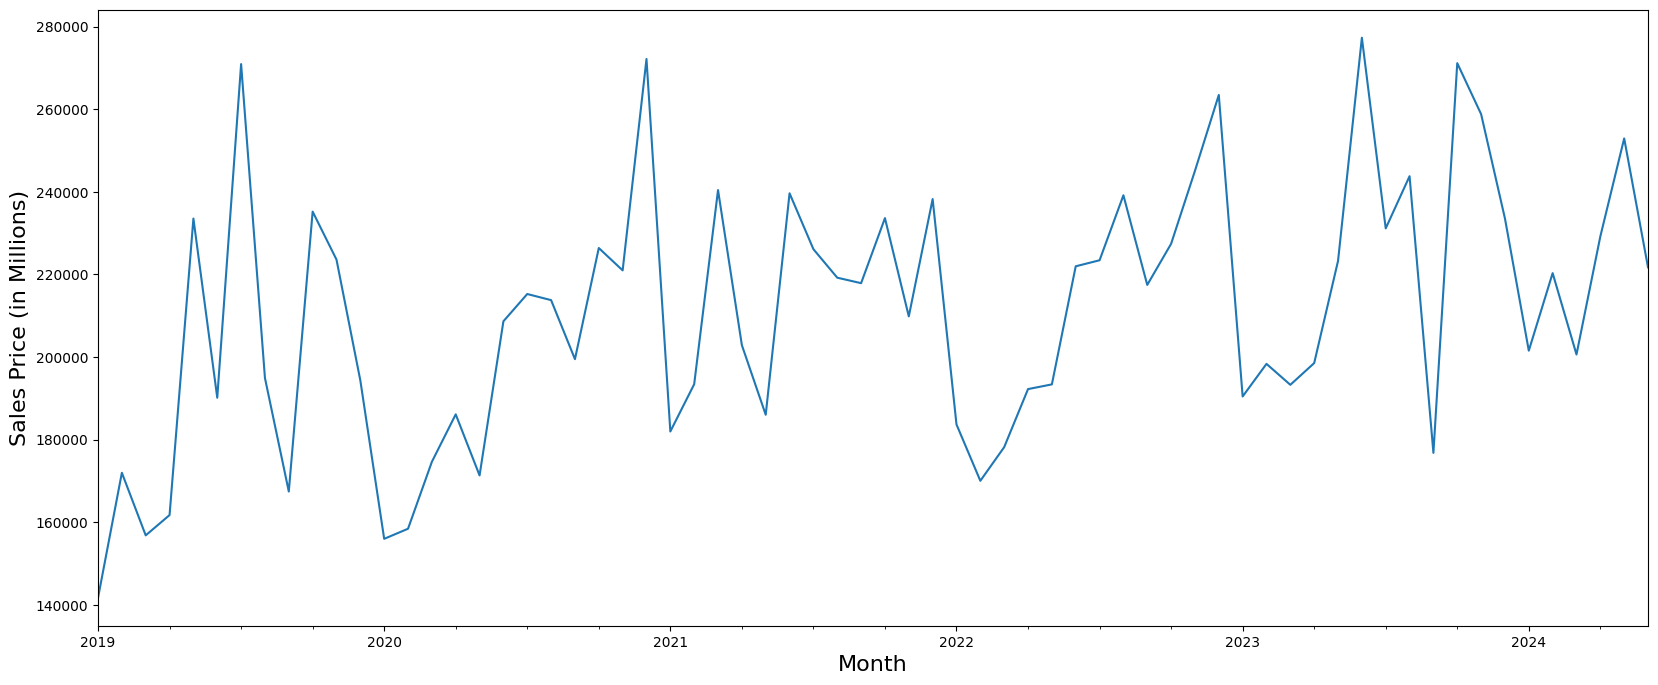

In [34]:
df['month'] = df['date'].dt.to_period('M')

sales_per_month = df.groupby(['month'])['sale_dollars'].sum()

sales_per_month.plot(figsize=(20, 8))
plt.xlabel("Month", fontsize=16)
plt.ylabel("Sales Price (in Millions)", fontsize=16)
plt.show()

**Observation:**

* The month of December 2021 had the highest revenue generated which was about 42 million USD.
* The month of June 2021 had the second highest revenue generated which was about 38 million USD.

In [35]:
revenue_per_category = df.groupby('category_name')['sale_dollars'].sum().sort_values(ascending=False)
print(f"The product with the most revenue is {revenue_per_category.index[0]} with a total revenue of {revenue_per_category[0].astype(int):,} USD")

The product with the most revenue is AMERICAN VODKAS with a total revenue of 2,068,509 USD


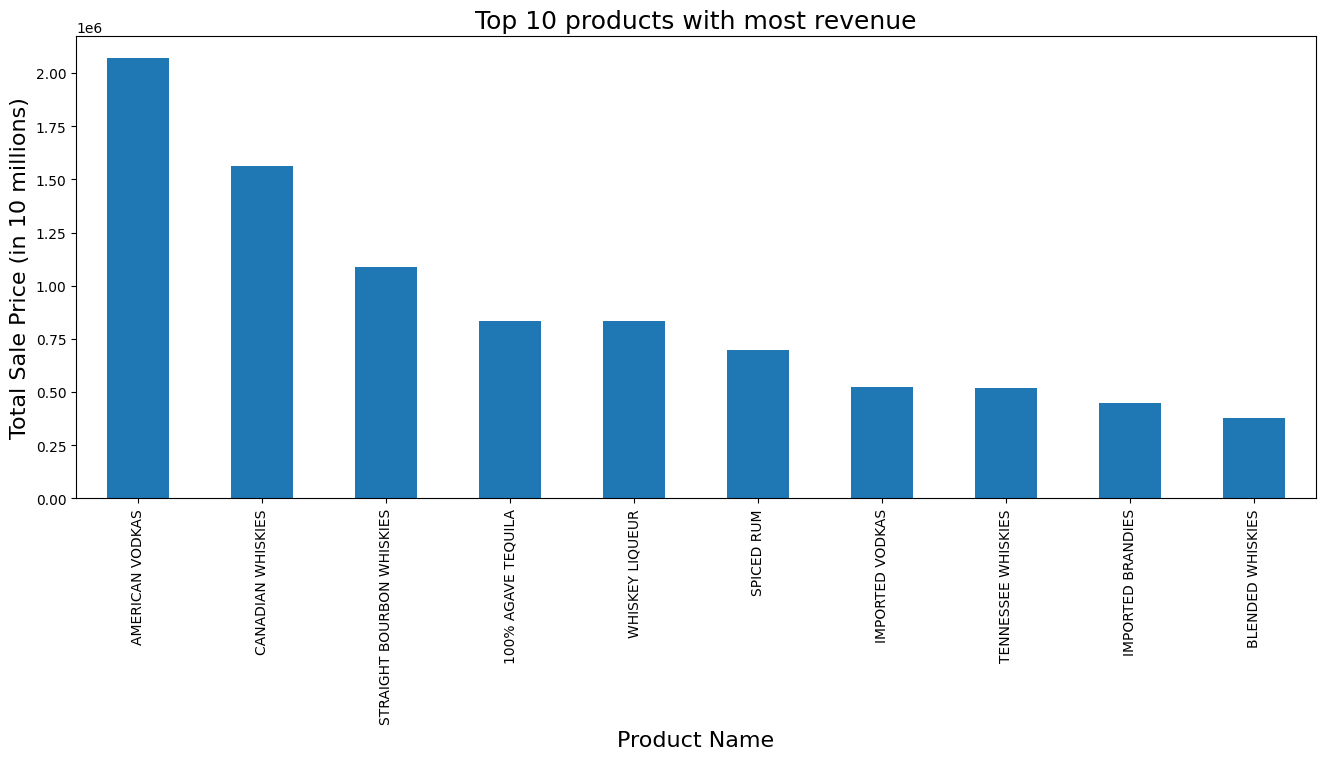

In [36]:
revenue_per_category[:10].plot(kind="bar", figsize=(16, 6))
plt.xlabel("Product Name", fontsize=16)
plt.ylabel("Total Sale Price (in 10 millions)", fontsize=16)
plt.title("Top 10 products with most revenue", fontsize=18)
plt.show()

### Question 3

How many stores ordered liquor? Which store has the most order?

In [37]:
print(f"{df['store_name'].nunique():,} different stores ordered liquor.")

2,490 different stores ordered liquor.


In [45]:
stores_with_most_order = df.groupby('store_name').size().to_frame("Number of orders").reset_index().sort_values(by="Number of orders", ascending=False)
stores_with_most_order

,store_name,Number of orders
1181,HY-VEE #3 / BDI / DES MOINES,672
741,CENTRAL CITY 2,662
1333,HY-VEE FOOD STORE / CEDAR FALLS,507
742,"CENTRAL CITY LIQUOR, INC.",492
70,BENZ DISTRIBUTING,445
...,...,...
192,CASEY'S #4319 / PERRY,1
186,CASEY'S #4294 / CORYDON,1
1381,HY-VEE GAS - PLEASANT HILL,1
2278,W&H COOPERATIVE OIL CO. / BADGER,1


In [46]:
print(f"The store with the greatest number of orders is {stores_with_most_order.iloc[0]['store_name']}, with a total order of {stores_with_most_order.iloc[0]['Number of orders']:,} orders.")

The store with the greatest number of orders is HY-VEE #3 / BDI / DES MOINES, with a total order of 672 orders.


## Checking for Seasonality

In [50]:
def adf_test(series):

    result = adfuller(series)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-value: {result[1]}')

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")

In [51]:
bottles_sold_per_day = df.groupby(['date'])['bottles_sold'].sum()
adf_test(bottles_sold_per_day)

ADF Statistics: -8.097979794141834
p- value: 1.3231606396820125e-12
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


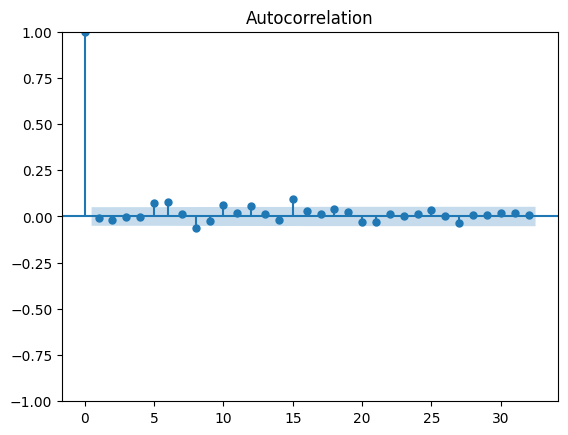

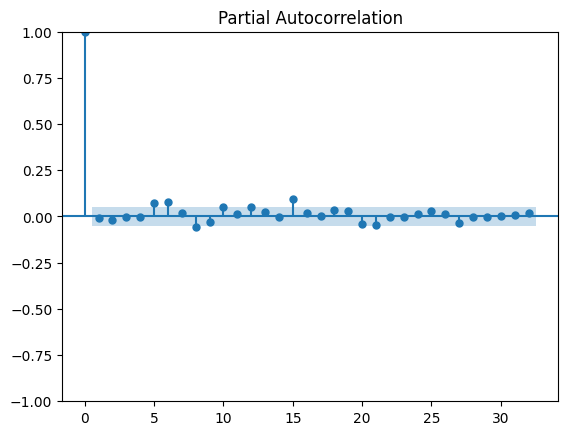

In [52]:
acf = plot_acf(bottles_sold_per_day)
pacf = plot_pacf(bottles_sold_per_day)

In [57]:
bottles_sold_jan2022_to_jan2023 = bottles_sold_per_day.loc["2022-01-01":"2023-01-31"].copy()
bottles_sold_jan2022_to_jan2023

date
2022-01-03    298
2022-01-04    429
2022-01-05    879
2022-01-06    335
2022-01-07    755
             ... 
2023-01-26    715
2023-01-27    575
2023-01-29     30
2023-01-30    404
2023-01-31    516
Name: bottles_sold, Length: 305, dtype: Int64

In [90]:
bottles_sold_per_day

date
2019-01-02    480
2019-01-03    514
2019-01-04    532
2019-01-07    875
2019-01-08    382
             ... 
2024-06-26    471
2024-06-27    607
2024-06-28    430
2024-06-29    541
2024-06-30    128
Name: bottles_sold, Length: 1509, dtype: Int64

In [100]:
dates = pd.date_range(start='2023-02-01', end='2023-04-30')

size = dates.size

val = [0] * size

bottles_sold_feb_to_april = pd.Series(val, index=dates)
bottles_sold_feb_to_april

2023-02-01    0
2023-02-02    0
2023-02-03    0
2023-02-04    0
2023-02-05    0
             ..
2023-04-26    0
2023-04-27    0
2023-04-28    0
2023-04-29    0
2023-04-30    0
Freq: D, Length: 89, dtype: int64

In [108]:
bottle_sold_jan2022_to_april2023 = pd.concat([bottles_sold_jan2022_to_jan2023, bottles_sold_feb_to_april], axis=0)

size_for_train = bottle_sold_jan2022_to_april2023.size - size  # Excluding the prediction dates
index = bottle_sold_jan2022_to_april2023.size - size_for_train # First index of prediction date

# Training dataset
train = bottle_sold_jan2022_to_april2023.iloc[:size_for_train] # Contains all dates from Jan/2022 - Jan/2023

# Test dataset
test = bottle_sold_jan2022_to_april2023.iloc[size_for_train:] # Contains all dates from Feb/2023 - April/2023

## SARIMAX Model

We'll use the [SARIMAX model](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html) as the data is seasonal.

- `order`: The ($p,d,q$) order of the model for the number of AR parameters, differences, and MA parameters.
  `d` must be an integer indicating the integration order of the process,
  while `p` and `q` may either be an integers indicating the AR and MA orders
  (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include.
- `seasonal_order` : The ($P,D,Q,s$) order of the seasonal component of the model for the
  $AR$ parameters, differences, $MA$ parameters, and periodicity.
  `D` must be an integer indicating the integration order of the process,
  while `P` and `Q` may either be an integers indicating the AR and MA
  orders (so that all lags up to those orders are included) or else
  iterables giving specific AR and / or MA lags to include.
  `s` is an integer giving the periodicity (number of periods in season),
  often it is 4 for quarterly data or 12 for monthly data.

In [109]:
model_sarima = SARIMAX(train.astype(int), order=(3, 0, 5), seasonal_order=(1, 0, 1, 12))

# Fitting the SARIMAX model
model_sarima_fit = model_sarima.fit(maxiter=500)

# Summary statistics of the trained model
model_sarima_fit.summary()

/opt/anaconda3/envs/bunge/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bunge/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bunge/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96093D+02    |proj g|=  6.24331D+02

At iterate    5    f=  7.69527D+00    |proj g|=  4.14849D-01

At iterate   10    f=  7.29236D+00    |proj g|=  5.90752D-02

At iterate   15    f=  7.22640D+00    |proj g|=  3.39035D-02

At iterate   20    f=  7.21267D+00    |proj g|=  7.50177D-03

At iterate   25    f=  7.20948D+00    |proj g|=  3.35984D-03

At iterate   30    f=  7.20888D+00    |proj g|=  1.08710D-02

At iterate   35    f=  7.20705D+00    |proj g|=  1.93854D-03

At iterate   40    f=  7.20686D+00    |proj g|=  2.64190D-04

At iterate   45    f=  7.20685D+00    |proj g|=  6.31317D-04

At iterate   50    f=  7.20640D+00    |proj g|=  5.82752D-03

At iterate   55    f=  7.20569D+00    |proj g|=  1.09671D-03

At iterate   60    f=  7.20532D+00    |proj g|=  8.94778D-03

At iterate   65    f=  7.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  305
Model:             SARIMAX(3, 0, 5)x(1, 0, [1], 12)   Log Likelihood               -2197.440
Date:                              Fri, 02 Aug 2024   AIC                           4416.879
Time:                                      05:57:07   BIC                           4457.803
Sample:                                           0   HQIC                          4433.248
                                              - 305                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7764      0.173     -4.497      0.000      -1.115      -0.438
ar.L2          0.9758      0.018     54.205      0.000       0.940       1.011
ar.L3          0.8006      0.170      4.707      0.000       0.467       1.134
ma.L1          0.7823      0.192      4.084      0.000       0.407       1.158
ma.L2         -0.9259      0.097     -9.575      0.000      -1.115      -0.736
ma.L3         -0.8282      0.179     -4.633      0.000      -1.179      -0.478
ma.L4         -0.0104      0.095     -0.110      0.912      -0.196       0.175
ma.L5          0.0732      0.081      0.902      0.367      -0.086       0.232
ar.S.L12       0.9618      0.069     13.939      0.000       0.827       1.097
ma.S.L12      -0.9901      0.076    -13.040      0.000      -1.139      -0.841
sigma2      1.038e+05   2.13e-06   4.88e+10      0.000    1.04e+05    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1916.59
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             1.66
Prob(H) (two-sided):                  0.07   Kurtosis:                        14.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+26. Standard errors may be unstable.
"""

In [114]:
dates

DatetimeIndex(['2023-02-01', '2023-02-02', '2023-02-03', '2023-02-04',
               '2023-02-05', '2023-02-06', '2023-02-07', '2023-02-08',
               '2023-02-09', '2023-02-10', '2023-02-11', '2023-02-12',
               '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
               '2023-02-17', '2023-02-18', '2023-02-19', '2023-02-20',
               '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24',
               '2023-02-25', '2023-02-26', '2023-02-27', '2023-02-28',
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10', '2023-03-11', '2023-03-12',
               '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16',
               '2023-03-17', '2023-03-18', '2023-03-19', '2023-03-20',
               '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24',
               '2023-03-25', '2023-03-26', '2023-03-27', '2023-03-28',
      

In [119]:
train.loc["2022-04-29"]

641

In [128]:
p = model_sarima_fit.predict(start="2022-02-01", end="2022-04-29", dynamic=False)
p = p.to_frame("ypred").reset_index().rename(columns={"index": "date"})
p["date"] = p.date + pd.DateOffset(years=1)
p

,date,ypred
0,2023-02-01,629.227109
1,2023-02-02,690.770118
2,2023-02-03,688.581395
3,2023-02-04,656.353248
4,2023-02-07,715.548787
...,...,...
66,2023-04-25,569.814717
67,2023-04-26,546.121954
68,2023-04-27,583.827388
69,2023-04-28,575.192908


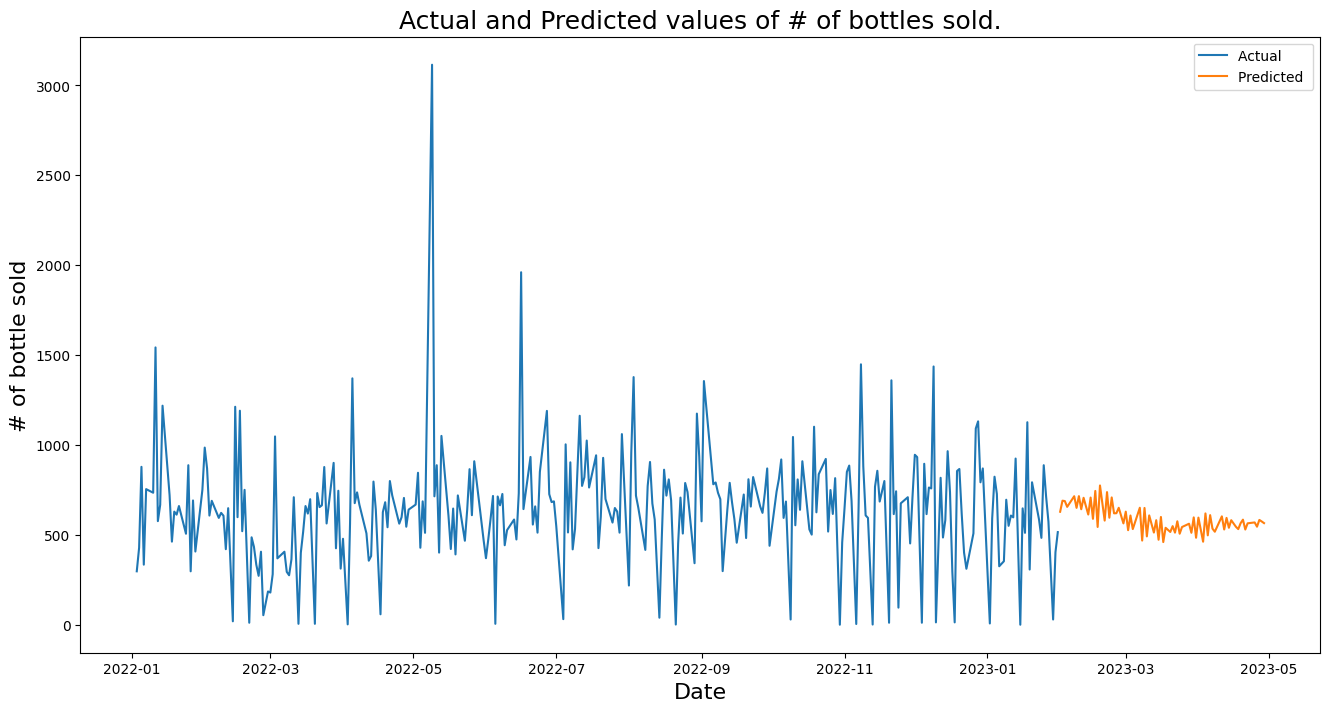

In [129]:
# Generating predictions using the SARIMAX model
pred_Sarima = model_sarima_fit.predict(1, index)
pred_sarima = model_sarima_fit.predict(start="2022-02-01", end="2022-04-29", dynamic=True)

plt.figure(figsize=(16, 8))
sns.lineplot(x=train.index, y=train.values, label='Actual ')
# sns.lineplot(x=test.index, y=pred_Sarima, label='Predicted ')
sns.lineplot(x=p.date, y=p.ypred, label='Predicted ')

plt.ylabel("# of bottle sold", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.title("Actual and Predicted values of # of bottles sold.", fontsize=18)
plt.show()

In [139]:
p = p.merge(bottles_sold_per_day.loc[bottles_sold_per_day.index.isin(p.date)], right_index=True, left_on="date")
p

,date,ypred,bottles_sold
0,2023-02-01,629.227109,795
1,2023-02-02,690.770118,732
2,2023-02-03,688.581395,899
4,2023-02-07,715.548787,632
5,2023-02-08,650.738458,843
6,2023-02-09,716.115814,1150
7,2023-02-10,643.041139,661
9,2023-02-13,613.710793,570
10,2023-02-14,708.129827,580
11,2023-02-15,589.773165,454


In [134]:
ypred = pred_Sarima.to_frame("ypred").reset_index().rename(columns={"index": "date"})
ypred["date"] = ypred.date + pd.DateOffset(years=1)
ypred

,date,ypred
0,2023-01-04,236.816988
1,2023-01-05,319.984684
2,2023-01-06,495.015142
3,2023-01-07,465.257488
4,2023-01-10,464.210115
...,...,...
84,2023-04-21,530.392836
85,2023-04-22,564.890363
86,2023-04-25,569.814717
87,2023-04-26,546.121954


In [136]:
ypred = ypred.merge(bottles_sold_per_day.loc[bottles_sold_per_day.index.isin(p.date)], right_index=True, left_on="date")

In [137]:
ypred

,date,ypred,bottles_sold
20,2023-02-01,629.227109,795
21,2023-02-02,690.770118,732
22,2023-02-03,688.581395,899
24,2023-02-07,715.548787,632
25,2023-02-08,650.738458,843
26,2023-02-09,716.115814,1150
27,2023-02-10,643.041139,661
29,2023-02-13,613.710793,570
30,2023-02-14,708.129827,580
31,2023-02-15,589.773165,454


In [138]:
mean_squared_error(ypred.bottles_sold, ypred.ypred)

75661.05520410746

In [140]:
mean_squared_error(p.bottles_sold, p.ypred)

77237.03687606397

In [141]:
mean_absolute_error(ypred.bottles_sold, ypred.ypred)

184.4316625535011

In [142]:
mean_absolute_error(p.bottles_sold, p.ypred)

188.33298588583813

In [143]:
def feature_engineering(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['total_sales'] = df['bottles_sold'] * df['sale_dollars']
    return df


df = feature_engineering(df)
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,month,year,day,day_of_week,total_sales
0,RINV-04678500004,2023-06-07,6195,DT LIQUOR LLC / DEWITT,301 11TH STREET,DEWITT,52742.0,POINT(-90.534765967 41.826022985),None,CLINTON,...,10.59,-30,-317.70,-52.5,-13.86,6,2023,7,2,9531.0
1,RINV-05156500143,2024-02-28,2201,HAPPY'S WINE & SPIRITS WHOLESALE,5925 UNIVERSITY AVE,CEDAR FALLS,50613.0,POINT(-92.429482021 42.512313981),None,BLACK HAWK,...,26.28,-48,-1261.44,-36.0,-9.51,2,2024,28,2,60549.12
2,RINV-04740600093,2023-07-10,6144,NORTHSIDE LIQUOR AND GROCERY / MASON CITY,1303 N FEDERAL,MASON CITY,50401.0,POINT(-93.200731023 43.163723016),None,CERRO GORDO,...,26.24,-24,-629.76,-18.0,-4.75,7,2023,10,0,15114.24
3,RINV-05218200037,2024-04-11,2656,HY-VEE FOOD STORE / CORNING,300 10TH ST,CORNING,50841.0,POINT(-94.732615023 40.992144989),None,ADAMS,...,33.75,-18,-607.50,-13.5,-3.56,4,2024,11,3,10935.0
4,RINV-04533600214,2023-03-03,2633,HY-VEE #3 / BDI / DES MOINES,3221 SE 14TH ST,DES MOINES,50320,POINT(-93.5968 41.55392),None,POLK,...,24.74,-12,-296.88,-12.0,-3.17,3,2023,3,4,3562.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87099,INV-17782300007,2019-02-26,4255,FAREWAY STORES #058 / ORANGE CITY,512 8TH SE,ORANGE CITY,51041,None,84,SIOUX,...,15.68,1182,18533.76,2068.5,546.43,2,2019,26,1,21906904.32
87100,INV-32575400003,2020-12-09,3524,SAM'S CLUB 6568 / AMES,305 AIRPORT RD,AMES,50010.0,POINT(-93.613648 42.001123),85,STORY,...,15.68,1200,18816.00,2100.0,554.76,12,2020,9,2,22579200.0
87101,INV-47227100011,2022-05-09,2512,HY-VEE WINE AND SPIRITS / IOWA CITY,1720 WATERFRONT DR,IOWA CITY,52240.0,POINT(-91.530439 41.642724),52,JOHNSON,...,5.96,2400,14304.00,2400.0,634.01,5,2022,9,0,34329600.0
87102,INV-23017500001,2019-11-05,3814,COSTCO WHOLESALE #788 / WDM,7205 MILLS CIVIC PKWY,WEST DES MOINES,50266.0,POINT(-93.806489 41.561342),25,DALLAS,...,21.71,2016,43767.36,3528.0,931.99,11,2019,5,1,88234997.76


In [144]:
def feature_selection(df):
    selected_features = ['year', 'month', 'day', 'day_of_week', 'total_sales']
    X = df[selected_features]
    y = df['sale_dollars']
    return X, y


X, y = feature_selection(df)

In [145]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
def train_model(X_train, y_train, X_test, y_test, cv=3, test_size=0.2, random_state=42):

    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"]
    }

    model = RandomForestRegressor()
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return best_model, mse


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model, mse = train_model(X_train, X_test, y_train, y_test)

print(f'Best Model: {best_model}')
print(f'Mean Squared Error: {mse:,.2f}')

/opt/anaconda3/envs/bunge/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
def evaluate_model(model, X_test, y_test, verbose=True):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    if verbose:
        print(f"Mean Absolute Error: {mae:,.2f}")
        print(f"R2 Score: {r2:,.2f}")

    return mae, r2

mae, r2 = evaluate_model(best_model, X_test, y_test)